# Local supervised learning

In [1]:
import copy

from matplotlib import pyplot as plt
from matplotlib import patches
import numpy as np

## Hyperparameters

In [2]:
N_Is = [5, 6, 3]
N_O = 4
N_EX = 20
MAX_EPOCHS = 1000
WAIT = MAX_EPOCHS / 10

SEED = None

## Functions

In [3]:
def calc_output(Is, ws, b=None):
    output = np.sum([np.dot(I, w.T) for I, w in zip(Is, ws)], axis=0)
    if b is not None:
        output += b
    return output

def mse_loss(targ, pred):
    return ((targ - pred) ** 2).mean()
    
def weight_norm(ws, Lnorm=2):
    return np.sum([np.linalg.norm(w, ord=Lnorm) for w in ws])

def calc_all_losses(all_Is, ws, all_Os, b=None):
    loss = 0
    for Is, Os in zip(all_Is, all_Os):
        loss += mse_loss(Os, calc_output(Is, ws, b=b))
    return loss

def calc_max_output(all_Is, ws, b=None):
    return max([calc_output(Is, ws, b=b).max() for Is in all_Is])

In [46]:
def hebb_update(Is, ws, O, lr=1e-4, b=None):
    for i, I in enumerate(Is):
        if ws[i].shape != (len(O), len(I)):
            raise ValueError(
                f"w should have shape ({len(O)}, {len(I)}), "
                f"but found {ws[i].shape}.")
        ws[i] += lr * np.outer(O, I)

    if b is not None:
        if len(b) != len(O):
            raise ValueError(
                f"b should have the length of O ({len(O)}), "
                f"but found {len(b)}."
            )
        b += lr * O
        
    return

def get_hebb_norm(ws, Lnorm=2):
    norm = np.sum([np.sum(w ** Lnorm, axis=-1) for w in ws], axis=0) ** (1 / Lnorm)    
    return norm

def hebb_norm_update(Is, ws, O, lr=1e-4, Lnorm=2, b=None, norm_pred=False): 
    # in-place update
    hebb_update(Is, ws, O, lr=lr, b=b)

    # after in-place update
    if Lnorm == 1:
        O_for_norm = 0
        if norm_pred:
            O_for_norm = calc_output(Is, ws, b=b)
        
        w_norm = np.mean(np.concatenate(Is)) * O_for_norm
        if b is not None:
            b_norm = O_for_norm
    else:
        w_norm = get_hebb_norm(ws, Lnorm=Lnorm)
        if b is not None:
            b_norm = get_hebb_norm([b], Lnorm=Lnorm)
    
    # adjustment
    for i in range(len(ws)):
        if Lnorm == 1:
            ws[i] -= lr * w_norm.reshape(-1, 1)
            # print(get_hebb_norm(ws, Lnorm=Lnorm))
        else:
            ws[i] /= w_norm.reshape(-1, 1)
            print(get_hebb_norm(ws, Lnorm=Lnorm))
            import pdb; pdb.set_trace()
    if b is not None:
        if Lnorm == 1:
            b -= lr * b_norm
        else:
            b /= b_norm

    return

def get_oja_sub(ws, O):
    sub = [np.dot((O ** 2).reshape(1, -1), w) for w in ws]
    return sub

def oja_update(Is, ws, O, lr=1e-4, b=None, norm_pred=False):
    # before in-place update
    O_for_norm = O
    if norm_pred:
        O_for_norm = calc_output(Is, ws, b=b)
        
    w_subs = get_oja_sub(ws, O_for_norm)
    if b is not None:
        b_sub = get_oja_sub([b], O_for_norm)[0]
      
    # in-place update
    hebb_update(Is, ws, O, lr=lr, b=b)
    
    # adjustment
    for i in range(len(ws)):
        ws[i] -= lr * w_subs[i]
    if b is not None:
        b -= lr * b_sub
        
    return

In [47]:
RULES = {
    "hebb": ("Hebbian learning", hebb_update),
    "hebb_L1_norm": ("Norm. Hebbian learning (L1)\n(norm. based on pred.)", hebb_norm_update),
    "hebb_L2_norm": ("Norm. Hebbian learning (L2)", hebb_norm_update),
    "oja": ("Oja's rule", oja_update),
    "oja_pred": ("Oja's rule\n(norm. based on pred.)", oja_update),
}

## Train

In [48]:
def init_data(n_Is=[5, 6, 3], n_O=4, n_ex=20, seed=None, O_factor=1):
    randst = np.random.RandomState(seed=seed)
    all_Is = [[randst.rand(n_I) for n_I in N_Is] for _ in range(N_EX)]
    all_Os = randst.rand(N_EX, N_O) * O_factor
    return all_Is, all_Os

def compute_records(all_Is, all_Os, ws, b):
    records_dict = {
        "ws_L1_norm": weight_norm(ws, Lnorm=1),
        "b_L1_norm": weight_norm([b], Lnorm=1),
        "ws_L2_norm": weight_norm(ws, Lnorm=2),
        "b_L2_norm": weight_norm([b], Lnorm=2),
        "loss": calc_all_losses(all_Is, ws, all_Os),
        "max_out": calc_max_output(all_Is, ws),
    }
    return records_dict

def train(all_Is, all_Os, ws, b, rule="hebb"):
    rule_params = dict()
    if rule == "hebb_L1_norm":
        rule_params["Lnorm"] = 1
    elif rule == "hebb_L2_norm":
        rule_params["Lnorm"] = 2
    if rule in ["hebb_L1_norm", "oja_pred"]:
        rule_params["norm_pred"] = True
    rule_fct = RULES[rule][1]
    
    for i in range(len(all_Is)):
        rule_fct(all_Is[i], ws, all_Os[i], b=b, **rule_params)
    loss = calc_all_losses(all_Is, ws, all_Os, b=b)

    records_dict = compute_records(all_Is, all_Os, ws, b)

    return records_dict

def plot_results(all_Is, all_Os, records_dict, ax1D=None, rule="hebb"):

    if ax1D is None:
        fig, ax1D = plt.subplots(3, 1, sharex=True, sharey="row", figsize=(3, 9))
    
    best_loss_ep = np.argmin(records_dict["loss"])
    best_loss = records_dict["loss"][best_loss_ep]
    num_epochs = len(records_dict["loss"])
    
    # mark best epoch
    label = f"ep. {best_loss_ep}\n{100 * best_loss / records_dict['loss'][0]:.2f}% of init."
    for i in range(3):
        ax1D[i].axvline(best_loss_ep, ls="dashed", color="k", label=label)
        label = None
    ax1D[0].legend(fontsize="small")
    
    # plot losses
    ax1D[0].plot(records_dict["loss"])
    rect = patches.Rectangle((0, 0), num_epochs, best_loss, lw=0, facecolor="red", alpha=0.25, zorder=-13)
    ax1D[0].add_patch(rect)
    
    # plot parameter norms
    for i in [1, 2]:
        ax1D[i].plot(records_dict[f"ws_L{i}_norm"], label="weights")
        ax1D[i].plot(records_dict[f"b_L{i}_norm"], label="biases")
        ax1D[i].legend(fontsize="small")
    
    # plot max output
    ax1D[3].plot(records_dict["max_out"])
    ax1D[3].axhline(all_Os.max(), ls="dotted", color="k", label="highest target\noutput")
    ax1D[3].legend(fontsize="small");

    # add titles and axis labels
    ax1D[0].set_title(f"{RULES[rule][0]}\nbest MSE={best_loss:.2f}", fontsize="medium", y=1.05);
    ax1D[0].set_ylabel("Losses")
    ax1D[1].set_ylabel("Parameter L1 norms")
    ax1D[2].set_ylabel("Parameter L2 norms")
    ax1D[3].set_ylabel("Max output")

    for sub_ax in ax1D.ravel():
        sub_ax.set_xlabel("Epochs")

    return ax1D
    
def run_rule(all_Is, all_Os, ax1D=None, seed=None, rule="hebb", max_epochs=1000):
    randst = np.random.RandomState(seed=seed)

    n_Is = [len(Is) for Is in all_Is]
    n_O = len(all_Os)
    
    if rule != "hebb":
        ws = [randst.normal(0, 0.3, N_O * n_I).reshape(N_O, n_I) for n_I in N_Is]
        b = randst.normal(0, 0.3, N_O)
    else:
        ws = [np.zeros((N_O, n_I)) for n_I in N_Is]
        b = np.zeros(N_O)

    records_dict = {key: [val] for key, val in compute_records(all_Is, all_Os, ws, b).items()}

    best_loss, waited = np.inf, 0
    for e in range(max_epochs):
        ep_records_dict = train(all_Is, all_Os, ws, b, rule=rule)      
        for key, val in ep_records_dict.items():
            records_dict[key].append(val)

        if ep_records_dict["loss"] < best_loss:
            best_loss = ep_records_dict["loss"]
        else:
            waited += 1
            if waited >= WAIT:
                break

    ax1D = plot_results(all_Is, all_Os, records_dict, ax1D=ax1D, rule=rule)

    return ax1D


def polish_axes(axes):
    for sub_ax in axes.ravel():
        sub_ax.spines[["right", "top"]].set_visible(False)
    for sub_ax in axes[:-1].ravel():
        sub_ax.set_xlabel("")
    for sub_ax in axes[:, 1:].ravel():
        sub_ax.set_ylabel("")

[1.08199947 0.90975133 1.00363359 1.14526712]
> /tmp/ipykernel_16323/2903443360.py(42)hebb_norm_update()
     40 
     41     # adjustment
---> 42     for i in range(len(ws)):
     43         if Lnorm == 1:
     44             ws[i] -= lr * w_norm.reshape(-1, 1)



ipdb>  ws[0]


array([[ 0.33723726, -0.07597679,  0.01830529, -0.32481061,  0.47861551],
       [ 0.49408911, -0.32646778,  0.1441326 , -0.2121148 ,  0.21454235],
       [ 0.18301206,  0.48220742,  0.25978621, -0.11618168,  0.41868704],
       [-0.41447748, -0.20013097,  0.02188098,  0.35570785,  0.12430152]])


ipdb>  np.sum(ws[0], axis=1)


array([ 0.43337065,  0.31418147,  1.22751105, -0.1127181 ])


ipdb>  np.sum(ws[0] ** 2, axis=1) + np.sum(ws[1] ** 2, axis=1) + np.sum(ws[2] ** 2, axis=1)


array([1.17072286, 0.82764747, 1.00728039, 1.31163678])


ipdb>  w_norm


array([1.145825  , 0.82422315, 1.00759149, 1.21763512])


ipdb>  np.sum([np.sum(w ** Lnorm, axis=-1) for w in ws], axis=0) ** (1 / Lnorm)


*** NameError: name 'Lnorm' is not defined


ipdb>  np.sum([np.sum(w ** 2, axis=-1) for w in ws], axis=0) ** (1 / 2)


array([1.08199947, 0.90975133, 1.00363359, 1.14526712])


ipdb>  np.sqrt(np.sum(ws[0] ** 2, axis=1) + np.sum(ws[1] ** 2, axis=1) + np.sum(ws[2] ** 2, axis=1))


array([1.08199947, 0.90975133, 1.00363359, 1.14526712])


ipdb>  np.sqrt(np.sum(ws[0] ** 2, axis=1) + np.sum(ws[1] ** 2, axis=1) + np.sum(ws[2] ** 2, axis=1)).mean()


1.0351628770936165


ipdb>  weight_norm(ws, Lnorm=2)


2.889715434665485


ipdb>  ws


[array([[ 0.33723726, -0.07597679,  0.01830529, -0.32481061,  0.47861551],
       [ 0.49408911, -0.32646778,  0.1441326 , -0.2121148 ,  0.21454235],
       [ 0.18301206,  0.48220742,  0.25978621, -0.11618168,  0.41868704],
       [-0.41447748, -0.20013097,  0.02188098,  0.35570785,  0.12430152]]), array([[ 0.228625  ,  0.1585429 , -0.19038066, -0.46651096, -0.28524864,
         0.04959312],
       [ 0.07201404,  0.09098789,  0.03351119, -0.09869386,  0.25054011,
         0.3584652 ],
       [-0.0810851 ,  0.27461929, -0.09001914, -0.28917111, -0.0536277 ,
         0.24532295],
       [-0.45251621, -0.08564256, -0.0486377 ,  0.54264944, -0.18602026,
        -0.15356644]]), array([[ 0.47407889, -0.07367328, -0.2665038 ],
       [-0.34393987,  0.02782743, -0.17459085],
       [ 0.03014692, -0.2272208 , -0.44234122],
       [ 0.56492084,  0.19722162, -0.17938044]])]


ipdb>  c


[1.03527169 0.96405946 1.00186126 1.06161339]
> /tmp/ipykernel_16323/2903443360.py(42)hebb_norm_update()
     40 
     41     # adjustment
---> 42     for i in range(len(ws)):
     43         if Lnorm == 1:
     44             ws[i] -= lr * w_norm.reshape(-1, 1)



ipdb>  ws


[array([[ 0.33723726, -0.07597679,  0.01830529, -0.32481061,  0.47861551],
       [ 0.49408911, -0.32646778,  0.1441326 , -0.2121148 ,  0.21454235],
       [ 0.18301206,  0.48220742,  0.25978621, -0.11618168,  0.41868704],
       [-0.41447748, -0.20013097,  0.02188098,  0.35570785,  0.12430152]]), array([[ 0.19952873,  0.13836572, -0.16615161, -0.4071398 , -0.24894607,
         0.04328158],
       [ 0.08737202,  0.1103923 ,  0.04065791, -0.11974167,  0.30397121,
         0.4349128 ],
       [-0.08047418,  0.27255023, -0.08934091, -0.28699241, -0.05322365,
         0.24347462],
       [-0.37163531, -0.07033516, -0.03994439,  0.4456585 , -0.15277176,
        -0.1261186 ]]), array([[ 0.47407889, -0.07367328, -0.2665038 ],
       [-0.34393987,  0.02782743, -0.17459085],
       [ 0.03014692, -0.2272208 , -0.44234122],
       [ 0.56492084,  0.19722162, -0.17938044]])]


ipdb>  w_norm


array([1.145825  , 0.82422315, 1.00759149, 1.21763512])


ipdb>  get_hebbian_norm(ws, Lnorm=2)


*** NameError: name 'get_hebbian_norm' is not defined


ipdb>  get_hebb_norm(ws, Lnorm=2)


array([1.03527169, 0.96405946, 1.00186126, 1.06161339])


ipdb>  ws[0] / 1.03527169


array([[ 0.3257476 , -0.07338826,  0.01768163, -0.31374432,  0.46230908],
       [ 0.4772555 , -0.31534503,  0.139222  , -0.20488805,  0.20723289],
       [ 0.17677685,  0.46577862,  0.2509353 , -0.11222337,  0.40442238],
       [-0.40035624, -0.19331251,  0.02113549,  0.34358889,  0.12006657]])


ipdb>  new_norm = get_hebb_norm(ws, Lnorm=2)
ipdb>  ws[0].T / new_norm


array([[ 0.32574759,  0.51250896,  0.18267206, -0.39042225],
       [-0.07338826, -0.33863864,  0.48131157, -0.18851587],
       [ 0.01768163,  0.14950592,  0.25930358,  0.02061106],
       [-0.31374432, -0.22002252, -0.11596584,  0.33506346],
       [ 0.46230908,  0.22254058,  0.4179092 ,  0.11708737]])


ipdb>  get_hebb_norm(ws[0].T / new_norm, Lnorm=2)


1.325268627267758


ipdb>  get_hebb_norm([ws[0].T / new_norm, ws[1].T / new_norm, ws[2].T / new_norm], Lnorm=2)


*** ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.


ipdb>  ws[1].T / new_norm


array([[ 0.19273078,  0.09062929, -0.08032467, -0.35006653],
       [ 0.1336516 ,  0.11450778,  0.27204389, -0.06625308],
       [-0.16049082,  0.04217365, -0.08917494, -0.03762612],
       [-0.39326855, -0.12420569, -0.28645924,  0.41979359],
       [-0.24046449,  0.31530338, -0.05312477, -0.14390527],
       [ 0.04180698,  0.45112653,  0.24302229, -0.11879899]])


ipdb>  ws[2].T / new_norm


array([[ 0.45792703, -0.35676209,  0.03009091,  0.53213425],
       [-0.07116323,  0.02886485, -0.22679866,  0.18577537],
       [-0.25742401, -0.18109967, -0.44151943, -0.16896965]])


ipdb>  new_vals = [ws[0] / new_norm.T, ws[1] / new_norm.T, ws[2] / new_norm.T]


*** ValueError: operands could not be broadcast together with shapes (4,5) (4,)


ipdb>  new_norm = new_norm.reshape(1, -1)
ipdb>  get_hebb_norm([ws[0].T / new_norm, ws[1].T / new_norm, ws[2].T / new_norm], Lnorm=2)


*** ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.


ipdb>  get_hebb_norm([ws[0] / new_norm, ws[1] / new_norm, ws[2] / new_norm], Lnorm=2)


*** ValueError: operands could not be broadcast together with shapes (4,5) (1,4)


ipdb>  ws[0].shape


(4, 5)


ipdb>  new_norm.shape


(1, 4)


ipdb>  new_norm = new_norm.reshape(-1, 1)
ipdb>  get_hebb_norm([ws[0] / new_norm, ws[1] / new_norm, ws[2] / new_norm], Lnorm=2)


array([1., 1., 1., 1.])


ipdb>  w_norm


array([1.145825  , 0.82422315, 1.00759149, 1.21763512])


ipdb>  exit


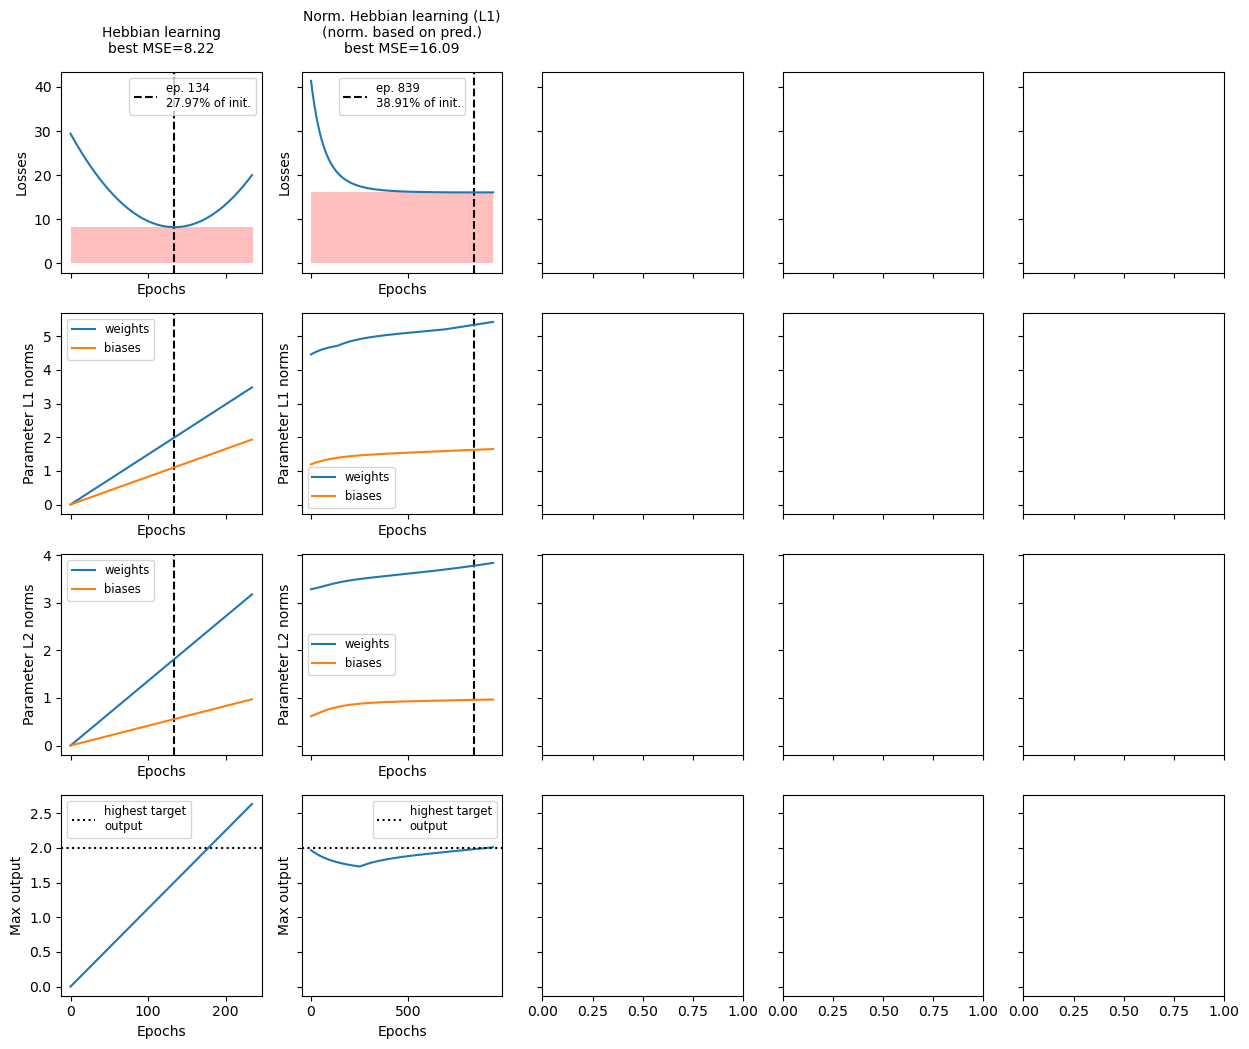

In [49]:
fig, axes = plt.subplots(4, len(RULES), sharex="col", sharey="row", figsize=(3 * len(RULES), 12))

all_Is, all_Os = init_data(n_Is=N_Is, n_O=N_O, n_ex=N_EX, seed=SEED, O_factor=2)
for r, rule in enumerate(RULES.keys()):
    run_rule(all_Is, all_Os, ax1D=axes[:, r], rule=rule, seed=SEED, max_epochs=3000)

polish_axes(axes)